# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Homework 8: Reinforcement Learning [100 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>

**DISCLAIMER**: No public reproduction of this homework nor its solution is allowed without the explicit consent of their authors.



<hr style="height:2pt">

---

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit.
- Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
# Numpy and plotting libraries

import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# Overview

The objective of this homework assignment is to get a taste of implementing a planning algorithm in a very simple setting. 

<div class='exercise'><b>  Markov Decision Process [100 points] </b></div>


We have a hallway consisting of 5 blocks (states 0-4). There are two actions, which deterministically move the agent to the left or the right. More explicitly: Performing action “left” in state 0 keeps you in state 0, moves you from state 1 to state 0, from state 2 to state 1, state 3 to state 2, and state 4 to state 3. Performing action “right” in state 4 keeps you in state 4, moves you from state 3 to state 4, from state 2 to state 3, from state 1 to state 2, and from state 0 to state 1. The agent receives a reward of -1.0 if it starts any iteration in state 0, state 1, state 2, or state 3. The agent receives a reward of +10.0 if it starts in state 4. Let the discount factor γ = 0.75.

We provide class MDP that instantiates an object representing a Markov decision process and verifies shapes.

**1.1** MDP proble [10 pts]: Build an MDP representing the hallway setting described above, by completing the function `build_hallway_mdp()`. You need to specify the array T that encodes the transitions from state and actions into next states; and a reward vector R that specifies the reward for being at a certain state.

**1.2**  Policy Evaluation [20 pts]: Initialize a policy “left” for every state (a 1D numpy array). Implement policy evaluation as described in lecture (also in Chapter 4 of [Sutton and Barto](http://incompleteideas.net/book/RLbook2018.pdf)). That is, for each possible starting state, what is the expected sum of future rewards for this policy? Using an iterative approach, how many iterations did it take for the value of the policy to converge to a precision of 10−5? 

**1.3**  Q-function Computation [20 pts]: Compute the Q-function for the `always_left` policy above. Do you see any opportunties for policy improvement?

**1.4** Policy Iteration [20 pts]: Using your solutions to questions 1.2 and 1.3 above, implement policy iteration. Report the sequence of policies you find starting with the policy “left” in every state. How many rounds of policy iteration are required to converge to the optimal policy? 

**1.5** [10 pts] What are the effects of different choices of the discount factor on the convergence of policy evaluation? Run policy evaluation for discount factor $\gamma \in [ 10^{-12}, 10^{-3}, 0.1, 0.33, 0.67, 0.9, 0.95, 0.99]$.

**1.6** [20 pts] What happens if the transitions are stochastic? Recode the MDP with probability of switching to the opposite action of 0.1. What are now the values when following the optimal policy?

In [3]:
class MDP(object):
    """Wrapper for a discrete Markov decision process that makes shape checks"""
    
    def __init__(self, T, R, discount):
        """Initialize the Markov Decision Process.
        - `T` should be a 3D array whose dimensions represent initial states,
          actions, and next states, respectively, and whose values represent
          transition probabilities.
        - `R` should be a 1D array describing rewards for beginning each
          timestep in a particular state (or a 3D array like `T`). It will be
          transformed into the appropriate 3D shape.
        - `discount` should be a value in [0,1) controlling the decay of future
          rewards."""
        Ds, Da, _ = T.shape
        if T.shape not in [(Ds, Da, Ds)]:
            raise ValueError("T should be in R^|S|x|A|x|S|")
        if R.shape not in [(Ds, Da, Ds), (Ds,)]:
            raise ValueError("R should be in R^|S| or like T")
        if discount < 0 or discount >= 1:
            raise ValueError("discount should be in [0,1)")
        if R.shape == (Ds,):  # Expand R if necessary
            R = np.array([[[R[s1] for s2 in range(Ds)] for a in range(Da)] for s1 in range(Ds)])
        self.T = T
        self.R = R
        self.discount = discount
        self.num_states = Ds
        self.num_actions = Da
        self.states = np.arange(Ds)
        self.actions = np.arange(Da)

**1.1** MDP proble [10 pts]: Build an MDP representing the hallway setting described above, by completing the function `build_hallway_mdp()`. You need to specify the array T that encodes the transitions from state and actions into next states; and a reward vector R that specifies the reward for being at a certain state.


In [4]:
def build_hallway_mdp():
    """Build an MDP representing the hallway setting described."""
    # your code here
    
    T = np.array([[[1,0,0,0,0],[0,1,0,0,0]],
                  [[1,0,0,0,0],[0,0,1,0,0]],
                  [[0,1,0,0,0],[0,0,0,1,0]],
                  [[0,0,1,0,0],[0,0,0,0,1]],
                  [[0,0,0,1,0],[0,0,0,0,1]]])
    R = np.array([-1,-1,-1,-1,10])
    
    # end of your code here
    return MDP(T, R, 0.75)

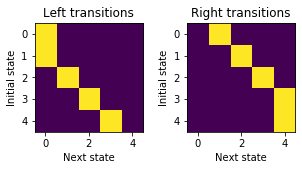

In [5]:
# Run for sanity check
mdp = build_hallway_mdp()

plt.figure(figsize=(5,2))
plt.subplot(121, title='Left transitions')
plt.imshow(mdp.T[:,0,:])
plt.ylabel("Initial state"); plt.xlabel('Next state')
plt.subplot(122, title='Right transitions')
plt.imshow(mdp.T[:,1,:])
plt.ylabel("Initial state"); plt.xlabel('Next state')
plt.show()

**1.2**  Policy Evaluation [20 pts]: Initialize a policy “left” for every state (a 1D numpy array). Implement policy evaluation as described in lecture (also in Chapter 4 of [Sutton and Barto](http://incompleteideas.net/book/RLbook2018.pdf)). That is, for each possible starting state, what is the expected sum of future rewards for this policy? Using an iterative approach, how many iterations did it take for the value of the policy to converge to a precision of 10−5?


In [6]:
def build_always_left_policy():
    """Build a policy representing the action "left" in every state."""
    # your code here
    return np.array([[1,0],[1,0],[1,0],[1,0],[1,0]])

In [7]:
def iterative_value_estimation(mdp, policy, tol=1e-5):
    """Value estimation algorithm from page 75, Sutton and Barto. Returns an
    estimate of the value of a given policy under the MDP (with the number of
    iterations required to reach specified tolerance)."""
    V = np.zeros(mdp.num_states)
    num_iters = 0
    
    # your code here
    
    while True:
        theta = 0
        for s in range(mdp.num_states - 1):
            num_iters += 1
            v = 0
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                s1 = 0
                for prob in mdp.T[s][a]:
                    if s1 <= 3:
                        s1 = s1+1
                        v += action_prob * prob * (mdp.R[s,a,s1] + mdp.discount * V[s1])
            theta = max(theta, np.max(np.abs(v - V[s])))
            V[s] = v
        # Check Convergence
        if theta < tol:
            break
    
    # end of your code here
    return V, num_iters

Policy value was:
[-4. -4. -4. -4.  0.]


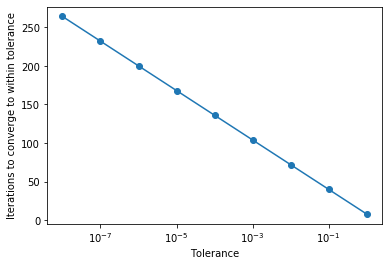

In [8]:
# Run for sanity check
always_left = build_always_left_policy()

values, iters = iterative_value_estimation(mdp, always_left)
print('Policy value was:')
print(values.round(4))

tols = np.logspace(0,-8,9)
iters = [iterative_value_estimation(mdp, always_left, tol=tol)[1] for tol in tols]
plt.plot(tols, iters, marker='o')
plt.xscale('log')
plt.xlabel("Tolerance")
plt.ylabel("Iterations to converge to within tolerance")
plt.show()

<font color='red'><br />
<p style="text-indent: 25px;">That is, for each possible starting state, what is the expected sum of future rewards for this policy?</p>
<p style="text-indent: 25px;">Using an iterative approach, how many iterations did it take for the value of the policy to converge to a precision of 10−5?</p>
</font>
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**1.3**  Q-function Computation [20 pts]: Compute the Q-function for the `always_left` policy above. Do you see any opportunties for policy improvement?


In [9]:
# 1.3
def Q_function(mdp, policy, tol=1e-5):
    """Q function from Equation 4.6, Sutton and Barto. For each state and
    action, returns the value of performing the action at that state, then
    following the policy thereafter."""
    # your code here
    
    Q = np.zeros([mdp.num_states, mdp.num_actions])
    V = np.zeros(mdp.num_states)
    num_iters = 0
    for s in range(mdp.num_states):
        for a in range(mdp.num_actions):
            Q[s][a] = np.sum([policy[s, a] * (mdp.R[s, a, s1] + tol * V[s1]) for s1 in range(mdp.num_states)])
    # end of your code here
    assert Q.shape == (mdp.num_states, mdp.num_actions)
    return Q

In [10]:
# Run for sanity check

Q = Q_function(mdp, always_left)
print('Q function was:')
print(Q.round(4))

Q function was:
[[-5.  0.]
 [-5.  0.]
 [-5.  0.]
 [-5.  0.]
 [50.  0.]]


<font color='red'>*Your answer here*<br />
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">Do you see any opportunties for policy improvement?</p>
</font>
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**1.4** Policy Iteration [20 pts]: Using your solutions to questions 1.2 and 1.3 above, implement policy iteration. Report the sequence of policies you find starting with the policy “left” in every state. How many rounds of policy iteration are required to converge to the optimal policy?


In [11]:
# 1.4
def policy_iteration(mdp, init_policy=None, tol=1e-5):
    """Policy iteration algorithm from page 80, Sutton and Barto.
    Iteratively transform the initial policy to become optimal.
    Return the full path."""
    # your code here
    
    V = np.zeros(mdp.num_states)
    Q = np.zeros(mdp.num_states)
    Q_best = np.zeros(mdp.num_states)
    print("Initial policy")
    print(init_policy)
    policies = init_policy
    is_value_changed = True
    num_iters = 0
    while is_value_changed:
        theta = 0
        is_value_changed = False
        num_iters += 1
        # run value iteration for each state
        for s in range(mdp.num_states - 1):
            v = 0
            for a, action_prob in enumerate(init_policy[s]):
                # For each action, look at the possible next states...
                s1 = 0
                for prob in mdp.T[s][a]:
                    if s1 <= 3:
                        s1 = s1+1
                        v += action_prob * prob * (mdp.R[s,a,s1] + mdp.discount * V[s1])
            theta = max(theta, np.max(np.abs(v - V[s])))
            V[s] = v
        # Check Convergence
        if theta < tol:
            break
    for s in range(mdp.num_states):
        print("Run for state", s)
        Q_best = V[s]
        for a in range(mdp.num_actions):
            Q = np.argmax([init_policy[s, a] * (mdp.R[s, a, s1] + tol * V[s1]) for s1 in range(mdp.num_states)])
            print("Run for state, action, Q, and Q_best: |", s, '|', a,'|', Q, '|', Q_best, '|')
        if Q > Q_best:
            policies[s] = a
            Q_best = Q
            is_value_changed = True

    print("Iterations:", num_iters)

    print("Final policy")
    print(policies)
    
    # end of your code here
    return policies

In [12]:
# Sanity check

policy_iters = policy_iteration(mdp, always_left)
policy_iters

Initial policy
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
Run for state 0
Run for state, action, Q, and Q_best: | 0 | 0 | 4 | -1.0 |
Run for state, action, Q, and Q_best: | 0 | 1 | 0 | -1.0 |
Run for state 1
Run for state, action, Q, and Q_best: | 1 | 0 | 4 | -1.0 |
Run for state, action, Q, and Q_best: | 1 | 1 | 0 | -1.0 |
Run for state 2
Run for state, action, Q, and Q_best: | 2 | 0 | 4 | -1.0 |
Run for state, action, Q, and Q_best: | 2 | 1 | 0 | -1.0 |
Run for state 3
Run for state, action, Q, and Q_best: | 3 | 0 | 4 | -1.0 |
Run for state, action, Q, and Q_best: | 3 | 1 | 0 | -1.0 |
Run for state 4
Run for state, action, Q, and Q_best: | 4 | 0 | 4 | 0.0 |
Run for state, action, Q, and Q_best: | 4 | 1 | 0 | 0.0 |
Iterations: 1
Final policy
[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]]


array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0]])

<font color='red'>*Your answer here*<br />
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">How many rounds of policy iteration are required to converge to the optimal policy?</p>
</font><font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**1.5** [10 pts] What are the effects of different choices of the discount factor on the convergence of policy evaluation? Run policy evaluation for discount factor $\gamma \in [ 10^{-12}, 10^{-3}, 0.1, 0.33, 0.67, 0.9, 0.95, 0.99]$.


In [13]:
# 1.5
# your code here

discount_factors = np.array([10e-12, 10e-3, 0.1, 0.33, 0.67, 0.9, 0.95, 0.99])
iters_by_factor = [iterative_value_estimation(mdp, always_left, tol=discount)[1] for discount in discount_factors]

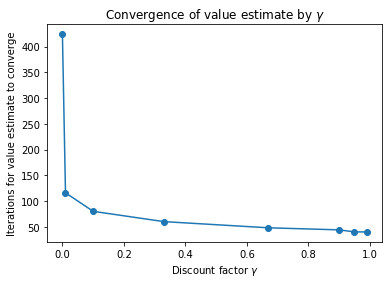

In [14]:
plt.plot(discount_factors, iters_by_factor, marker='o')
plt.xlabel('Discount factor $\gamma$')
plt.ylabel('Iterations for value estimate to converge')
plt.title("Convergence of value estimate by $\gamma$")
plt.show()

<font color='red'>*Your answer here*<br />
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">What are the effects of different choices of the discount factor on the convergence of policy evaluation?</p>
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>

**1.6** [20 pts] What happens if the transitions are stochastic? Recode the MDP with probability of switching to the opposite action of 0.1. What are now the values when following the optimal policy?

In [15]:
# 1.6
# your code here
def build_left_right_policy():
    return np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])

def choose_action(states):
    return np.random.choice(np.array([0,1]))

def policy_iteration(mdp, init_policy=None, tol=1e-5):
    """Policy iteration algorithm from page 80, Sutton and Barto.
    Iteratively transform the initial policy to become optimal.
    Return the full path."""
    # your code here
    
    V = np.zeros(mdp.num_states)
    Q = np.zeros(mdp.num_states)
    Q_best = np.zeros(mdp.num_states)
    print("Initial policy")
    print(init_policy)
    policies = init_policy
    is_value_changed = True
    num_iters = 0
    while is_value_changed:
        theta = 0
        is_value_changed = False
        num_iters += 1
        # run value iteration for each state
        for s in range(mdp.num_states - 1):
            v = 0
            c_a = choose_action(s)
            for a, action_prob in enumerate(init_policy[s][c_a]):
                # For each action, look at the possible next states...
                s1 = 0
                for prob in mdp.T[s][c_a]:
                    if s1 <= 3:
                        s1 = s1+1
                        v += action_prob * prob * (mdp.R[s,a,s1] + mdp.discount * V[s1])
            theta = max(theta, np.max(np.abs(v - V[s])))
            V[s] = v
        # Check Convergence
        if theta < tol:
            break    
    for s in range(mdp.num_states):
        #print("Run for state", s)
        Q_best = V[s]
        c_a = choose_action(s)
        for a in range(mdp.num_actions):
            Q = np.argmax([init_policy[s, a][c_a] * (mdp.R[s, a, s1] + tol * V[s1]) for s1 in range(mdp.num_states)])
            #print("Run for state, action, Q, and Q_best: |", s, '|', a,'|', Q, '|', Q_best, '|')
        if Q > Q_best:
            policies[s][c_a] = a
            Q_best = Q
            is_value_changed = True

    #print("Iterations:", num_iters)

    #print("Final policy")
    #print(policies)
    
    # end of your code here
    return policies

policy = build_left_right_policy()

policy_iters = policy_iteration(mdp, policy)
policy_iters

Initial policy
[[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]


array([[[1, 1],
        [0, 1]],

       [[1, 1],
        [0, 1]],

       [[1, 0],
        [1, 1]],

       [[1, 1],
        [0, 1]],

       [[1, 0],
        [1, 1]]])

In [16]:
init_policy = build_left_right_policy()
print(mdp.T[0])
print(policy[0])
print("left left", policy[0,0][0])
print("left right", policy[0,1][0])
print("right left", policy[0,0][1])
print("right right", policy[0,1][1])
for s in range(mdp.num_states):
    for a in range(mdp.num_actions):
        c_a = choose_action(s)
        #print(s, '|', a, '|', policy[s][c_a], '|', 'left' if c_a==0 else 'right')
        #print(s, '|', a, '|', policy[s, a][c_a], '    |', 'left' if c_a==0 else 'right')
        for r_a in range(mdp.num_actions):
            print(s, '|', a, '|', c_a, '|', 'left' if c_a==0 else 'right', 'left' if r_a==0 else 'right', policy[s, r_a][c_a])


[[1 0 0 0 0]
 [0 1 0 0 0]]
[[1 1]
 [0 1]]
left left 1
left right 0
right left 1
right right 1
0 | 0 | 1 | right left 1
0 | 0 | 1 | right right 1
0 | 1 | 0 | left left 1
0 | 1 | 0 | left right 0
1 | 0 | 0 | left left 1
1 | 0 | 0 | left right 0
1 | 1 | 1 | right left 1
1 | 1 | 1 | right right 1
2 | 0 | 1 | right left 0
2 | 0 | 1 | right right 1
2 | 1 | 0 | left left 1
2 | 1 | 0 | left right 1
3 | 0 | 0 | left left 1
3 | 0 | 0 | left right 0
3 | 1 | 1 | right left 1
3 | 1 | 1 | right right 1
4 | 0 | 0 | left left 1
4 | 0 | 0 | left right 1
4 | 1 | 1 | right left 0
4 | 1 | 1 | right right 1


In [17]:
for s in range(mdp.num_states - 1):
    c_a = choose_action(s)
    #print(c_a)
    for a, action_prob in enumerate(init_policy[s][c_a]):
        print('state:', s, 'policy:', init_policy[s][c_a], 'action:', a, 'transition', mdp.T[s][c_a])

state: 0 policy: [1 0] action: 0 transition [1 0 0 0 0]
state: 0 policy: [1 0] action: 1 transition [1 0 0 0 0]
state: 1 policy: [1 0] action: 0 transition [1 0 0 0 0]
state: 1 policy: [1 0] action: 1 transition [1 0 0 0 0]
state: 2 policy: [0 1] action: 0 transition [0 0 0 1 0]
state: 2 policy: [0 1] action: 1 transition [0 0 0 1 0]
state: 3 policy: [1 0] action: 0 transition [0 0 1 0 0]
state: 3 policy: [1 0] action: 1 transition [0 0 1 0 0]


<font color='red'>*Your answer here*<br />
<p style="text-indent: 25px;">What happens if the transitions are stochastic?</p>
<p style="text-indent: 25px;">What are now the values when following the optimal policy?</p>
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;"></p>
</font>